<a href="https://colab.research.google.com/github/carbaluar/Presentaci-n/blob/main/RTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generamos la base de Datos

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import datetime

In [4]:

dfAL = pd.read_excel('/content/DBRTO.xlsx')
dfAL.head()

,Timestamp,in CADC,out CADC,T FUB,T406,Velocidad M140,HAG,R
0,2020-11-03 09:00:00,206.673612,224.758101,195.818280,138.064697,8.898748,73.980766,0
1,2020-11-03 09:30:00,209.951967,225.060193,200.993333,144.010928,27.986787,156.013889,0
2,2020-11-03 10:00:00,212.247973,224.728009,207.600000,157.628570,28.104202,173.410031,1
3,2020-11-03 10:30:00,209.301215,224.422448,202.366667,162.052813,31.679949,187.017857,1
4,2020-11-03 11:00:00,207.480325,224.586800,197.988889,164.027985,32.133517,202.090097,1


In [5]:
dfAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       3911 non-null   datetime64[ns]
 1   in CADC         3911 non-null   float64       
 2   out CADC        3911 non-null   float64       
 3   T FUB           3911 non-null   float64       
 4   T406            3911 non-null   float64       
 5   Velocidad M140  3911 non-null   float64       
 6   HAG             3911 non-null   float64       
 7   R               3911 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 244.6 KB


### Discretizar Datos en Test/Train/Validation

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# divido entre train y test/validación en 70%/30%
dfAL_train, dfAL_test_validation = train_test_split(dfAL, train_size=0.7, stratify = dfAL["R"])

In [8]:

# divido entre train y test/validación en 15% y 15%
dfAL_test, dfAL_validation = train_test_split(dfAL_test_validation, train_size=0.5, stratify = dfAL_test_validation["R"])

In [9]:
dfAL_train.shape

(2737, 8)

In [10]:
dfAL_test.shape

(587, 8)

In [11]:
dfAL_validation.shape

(587, 8)

### Definir Modelos

#### Modelo Gaussiano

In [12]:
from sklearn.naive_bayes import GaussianNB

In [13]:
clf = GaussianNB(priors=None, var_smoothing= 0.1)

In [14]:
dfAL_train2 = dfAL_train[["out CADC","T FUB","HAG","R"]].copy()

In [15]:
clf.fit(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

GaussianNB(priors=None, var_smoothing=0.1)

In [16]:
clf.score(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

0.8220679576178297

In [17]:
dfAL_validation2 = dfAL_validation[["out CADC","T FUB","HAG","R"]].copy()
dfAL_test_validation2 = dfAL_test_validation[["out CADC","T FUB","HAG","R"]].copy()

In [18]:
clf.score(dfAL_validation2.drop("R",axis=1), dfAL_validation2["R"])


0.807495741056218

In [19]:
clf.score(dfAL_test_validation2.drop("R",axis=1), dfAL_test_validation2["R"])

0.817717206132879

In [20]:
BuscaSmoot = [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.000000000001]

In [21]:
scores = list()
for busca in BuscaSmoot:
    clf = GaussianNB(var_smoothing = busca)
    clf.fit(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])
    scores.append(clf.score(dfAL_validation2.drop("R",axis=1), dfAL_validation2["R"]))

print("Máximo score con un smoothing de: ", BuscaSmoot[scores.index(max(scores))], "--> valor de Score: ", max(scores))

Máximo score con un smoothing de:  0.1 --> valor de Score:  0.807495741056218


In [22]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
dfAL_train2.head()

,out CADC,T FUB,HAG,R
3053,190.619213,188.000000,215.387032,0
2625,199.071180,189.844444,215.179454,0
867,195.437501,193.276577,214.409091,0
933,195.564816,193.000000,193.169444,0
994,225.724539,202.197980,200.567957,1


In [23]:
clf.predict(np.array([[195,195,235]]))

array([0])

Matriz de Confusión 

In [24]:
y_true = 1*np.array(dfAL_validation2["R"])

In [25]:
y_true2 = 1*np.array(dfAL_test_validation2["R"])

In [26]:
y_pred = clf.predict_proba(dfAL_validation2.drop("R",axis=1))

In [27]:
y_pred2 = clf.predict_proba(dfAL_test_validation2.drop("R",axis=1))

In [28]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true,y_pred[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[247  74]
 [ 41 225]]


In [29]:
from sklearn.metrics import fbeta_score

In [30]:
print("Valor de F1 para un alfa= 0.25 -->", fbeta_score(y_true, y_pred[:,1]>0.25, beta=1))

Valor de F1 para un alfa= 0.25 --> 0.7964601769911505


In [31]:
print("Valor de Fbetascore para un alfa= 0.25 -->", fbeta_score(y_true, y_pred[:,1]>0.25, beta=2))

Valor de Fbetascore para un alfa= 0.25 --> 0.8253851797505503


In [32]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred2[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[503 140]
 [ 73 458]]


In [33]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [34]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred2[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Recall/Precision

In [35]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.8606403013182674 Valor de Precisions 0.7680672268907563 Valor de FPR 0.21461897356143078
Para un alfa 0.5 --> Valor de recall 0.7777777777777778 Valor de Precisions 0.8113948919449901 Valor de FPR 0.14930015552099535
Para un alfa 0.75 --> Valor de recall 0.7062146892655368 Valor de Precisions 0.8445945945945946 Valor de FPR 0.10730948678071539


Curva ROC

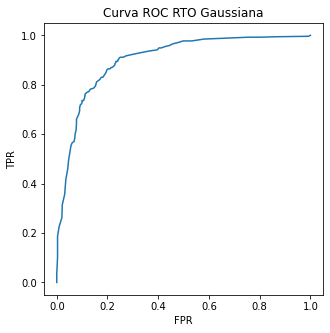

In [76]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC RTO Gaussiana")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

#### Modelo LDA

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [38]:
LDA_clf = LinearDiscriminantAnalysis()

In [39]:
LDA_clf.fit(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [40]:
LDA_clf.score(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

0.8359517720131531

In [41]:
LDA_clf.score(dfAL_validation2.drop("R",axis=1), dfAL_validation2["R"])

0.8091993185689949

In [42]:
LDA_clf.predict(np.array([[220,195,235]]))

array([1])

In [43]:
y_true2 = 1*np.array(dfAL_test_validation2["R"])

In [44]:
y_pred_LDA = LDA_clf.predict_proba(dfAL_test_validation2.drop("R",axis=1))

In [45]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_LDA[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[488 155]
 [ 64 467]]


In [46]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred_LDA[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [47]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.879472693032015 Valor de Precisions 0.7544426494345718 Valor de FPR 0.2363919129082426
Para un alfa 0.5 --> Valor de recall 0.783427495291902 Valor de Precisions 0.8156862745098039 Valor de FPR 0.14618973561430793
Para un alfa 0.75 --> Valor de recall 0.6836158192090396 Valor de Precisions 0.8501170960187353 Valor de FPR 0.09953343701399689


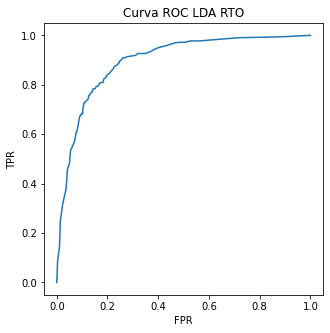

In [48]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC LDA RTO")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

#### Modelo QDA

In [49]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
QDA_clf = QuadraticDiscriminantAnalysis()

In [50]:
QDA_clf.fit(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [51]:
QDA_clf.score(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

0.8421629521373767

In [52]:
QDA_clf.score(dfAL_validation2.drop("R",axis=1), dfAL_validation2["R"])

0.8160136286201022

In [53]:
QDA_clf.predict(np.array([[220,195,230]]))

array([1])

In [54]:
y_true2 = 1*np.array(dfAL_test_validation2["R"])

In [55]:
y_pred_QDA = QDA_clf.predict_proba(dfAL_test_validation2.drop("R",axis=1))

 #### Modelo de Regresión Log.

In [56]:
from sklearn.linear_model import LogisticRegression
LR_clf=LogisticRegression(C=1e9, verbose=1)

In [57]:
LR_clf.fit(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [58]:
LR_clf.score(dfAL_train2.drop("R",axis=1), dfAL_train2["R"])

0.8344903178662769

In [59]:
LR_clf.score(dfAL_validation2.drop("R",axis=1), dfAL_validation2["R"])

0.8109028960817717

In [60]:
y_pred_LR = LR_clf.predict_proba(dfAL_test_validation2.drop("R",axis=1))

In [61]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_LR[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[449 194]
 [ 49 482]]


In [62]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred_LR[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [63]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.903954802259887 Valor de Precisions 0.712166172106825 Valor de FPR 0.30171073094867806
Para un alfa 0.5 --> Valor de recall 0.7740112994350282 Valor de Precisions 0.8236472945891784 Valor de FPR 0.1368584758942457
Para un alfa 0.75 --> Valor de recall 0.6421845574387948 Valor de Precisions 0.8676844783715013 Valor de FPR 0.08087091757387248


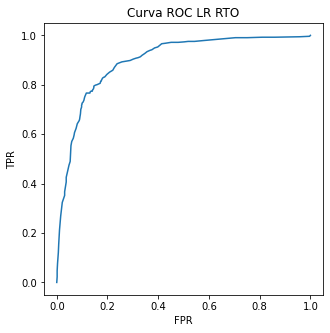

In [64]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC LR RTO")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

#### Modelo de Redes Neuronales

In [65]:
dfAL_train2.shape

(2737, 4)

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

In [67]:
RN_clf= Sequential()
RN_clf.add(BatchNormalization(input_shape=(3,)))
RN_clf.add(Dense(16, input_dim=5, activation='relu'))
RN_clf.add(Dense(1, activation='sigmoid'))

In [68]:
RN_clf.compile(loss='mean_squared_error',
              optimizer='SGD',
              metrics=['binary_accuracy'])

In [69]:
RN_clf.fit(dfAL_train2.drop("R",axis=1), dfAL_train2["R"], epochs=300)

Epoch 1/300
86/86 [==============================] - 1s 1ms/step - loss: 0.2520 - binary_accuracy: 0.5698
Epoch 2/300
86/86 [==============================] - 0s 1ms/step - loss: 0.2354 - binary_accuracy: 0.6483
Epoch 3/300
86/86 [==============================] - 0s 1ms/step - loss: 0.2176 - binary_accuracy: 0.7021
Epoch 4/300
86/86 [==============================] - 0s 1ms/step - loss: 0.2049 - binary_accuracy: 0.7373
Epoch 5/300
86/86 [==============================] - 0s 1ms/step - loss: 0.1950 - binary_accuracy: 0.7576
Epoch 6/300
86/86 [==============================] - 0s 1ms/step - loss: 0.1819 - binary_accuracy: 0.7703
Epoch 7/300
86/86 [==============================] - 0s 1ms/step - loss: 0.1750 - binary_accuracy: 0.7798
Epoch 8/300
86/86 [==============================] - 0s 1ms/step - loss: 0.1637 - binary_accuracy: 0.8059
Epoch 9/300
86/86 [==============================] - 0s 1ms/step - loss: 0.1573 - binary_accuracy: 0.8017
Epoch 10/300
86/86 [==========================

In [70]:
y_pred_RN = RN_clf.predict_proba(dfAL_test_validation2.drop("R",axis=1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [71]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_RN[:,0]>0.25))

Matriz de Confusión Alfa 0.25
[[484 159]
 [ 48 483]]


In [72]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred_RN[:,0]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [73]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9096045197740112 Valor de Precisions 0.7523364485981309 Valor de FPR 0.24727838258164853
Para un alfa 0.5 --> Valor de recall 0.783427495291902 Valor de Precisions 0.827037773359841 Valor de FPR 0.13530326594090203
Para un alfa 0.75 --> Valor de recall 0.6516007532956686 Valor de Precisions 0.8737373737373737 Valor de FPR 0.07776049766718507


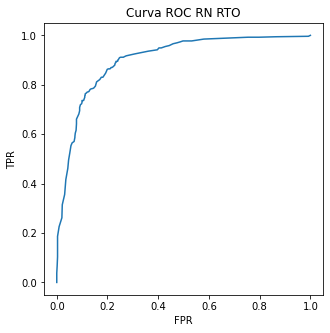

In [74]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC RN RTO")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()